In [1]:
from cellpose import plot, models

In [2]:
import matplotlib.pyplot as plt             # Library used for plotting
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import io, measure             # Module from skimage
import trackpy as tp                        # Library for particle tracking
from IPython.display import HTML            # To display a mp4 video


# Loading libraries
import matplotlib.pyplot as plt                    # Library used for plotting
from matplotlib import animation                   # Library to plot animations
import numpy as np                                 # library for array manipulation
import random                                      # Library to generate random numbers
from random import randrange                       # Library to generate random numbers
import math                                        # Library for math calculations
from scipy.spatial import KDTree                   # Module to link trajectories
import skimage                                     # Library for image manipulation
from skimage.util import random_noise              # Module to add random noise to the image
from skimage import measure                        # Module to find contours on images
import skimage                                     # Library for image manipulation
from skimage.io import imread                      # Module to read images
from IPython.display import HTML                   # To display a mp4 video
import urllib.request                              # importing library to download data
import pandas as pd
from scipy.stats import f_oneway
from cellpose import models


# ! pip install trackpy
import trackpy as tp # Library for particle tracking

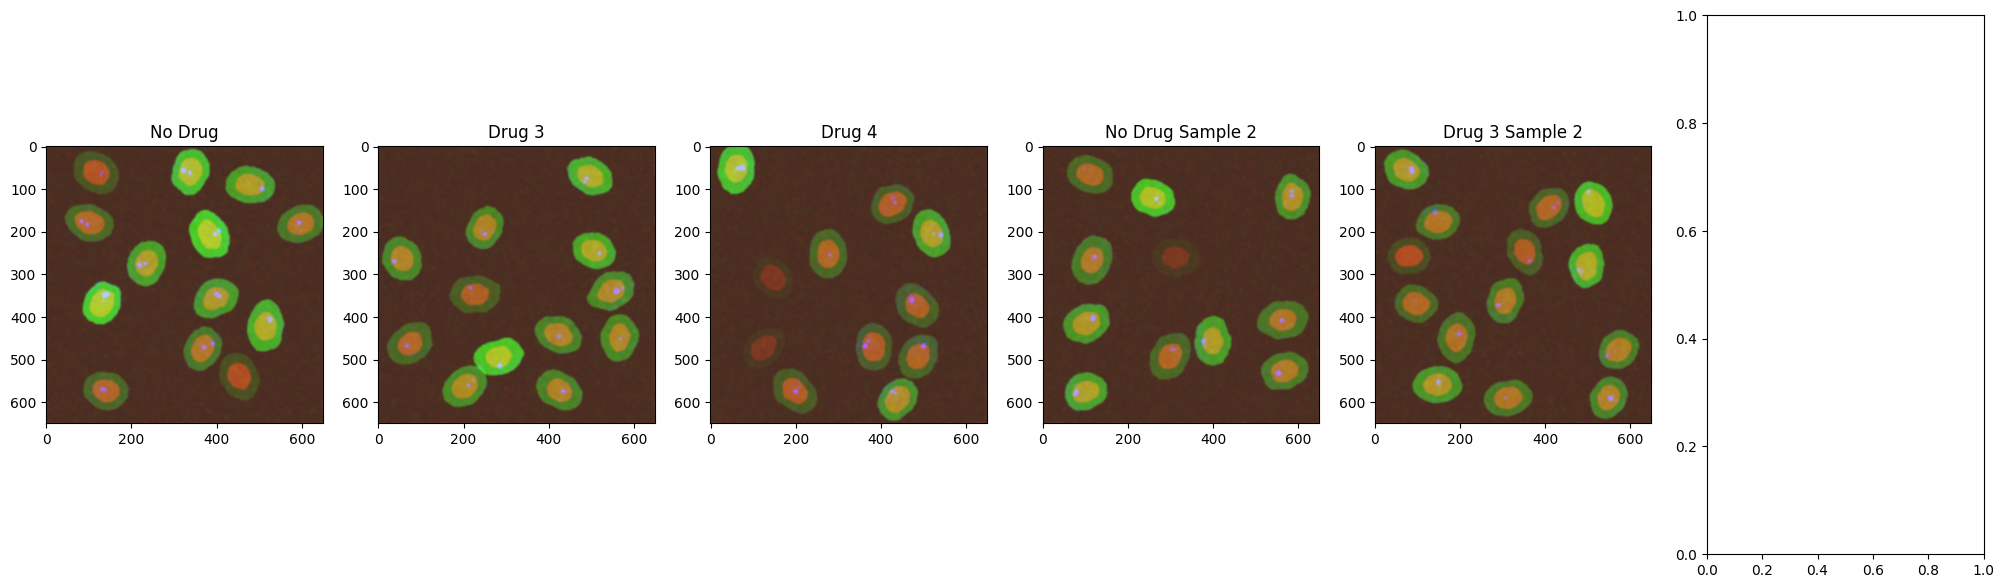

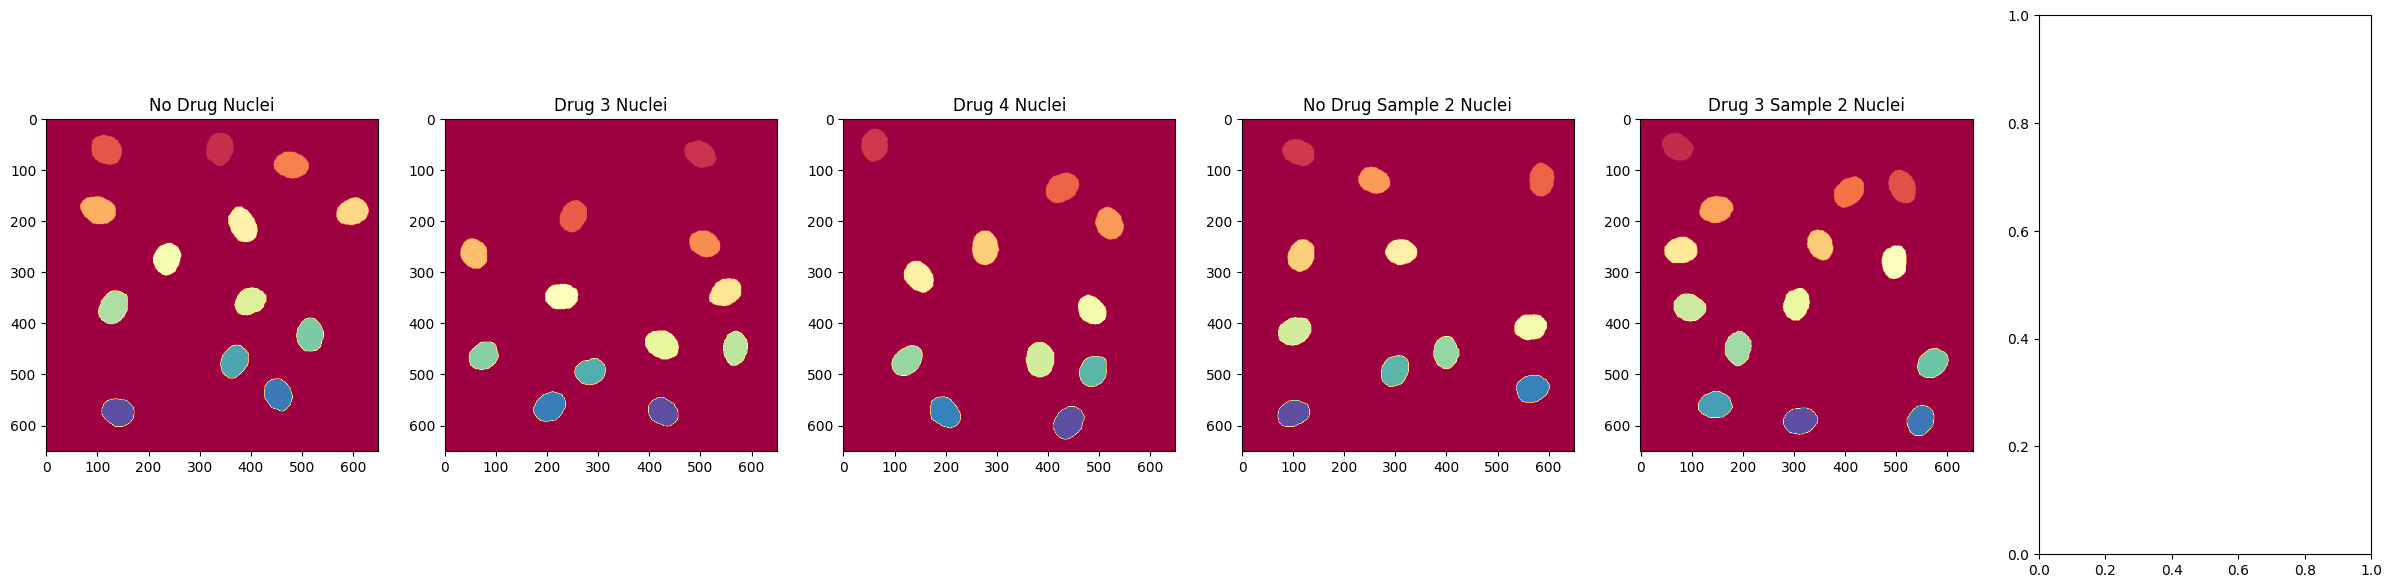

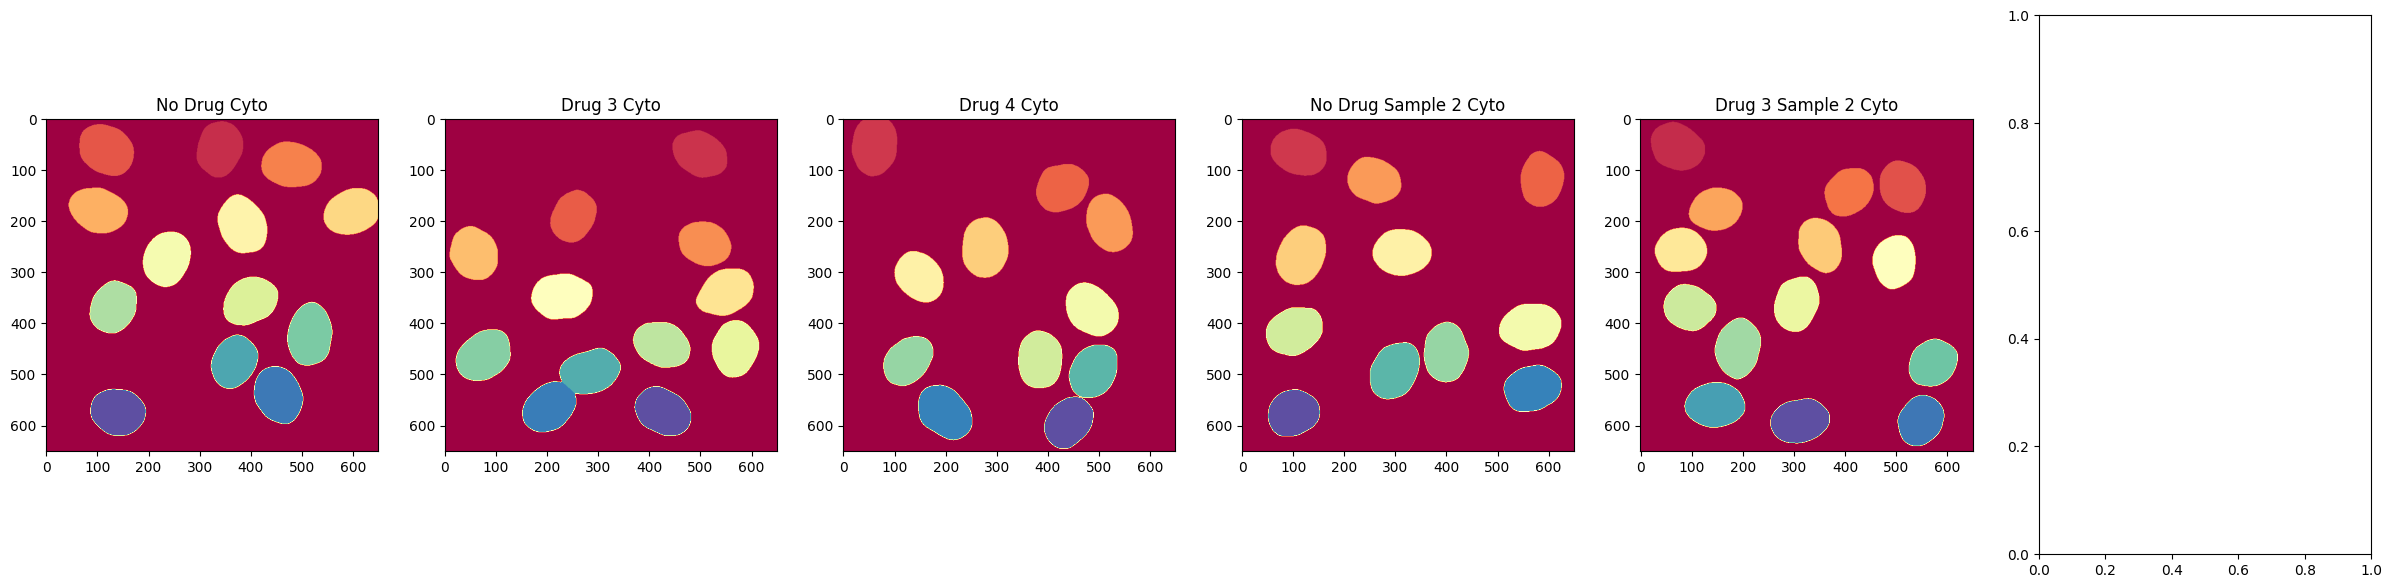

In [5]:
# 1) Example images of segmented cells.

# Loading the images
imgNoDrug = imread('./NoDrug/rep1_FOV1.tif')
imgDrug3 = imread('./Drug3_1000nM/rep1_FOV1.tif')
imgDrug4 = imread('./Drug4_1000nM/rep1_FOV1.tif')
imgDrug5 = imread('./Drug5_1000nM/rep1_FOV1.tif')
imgDrug6= imread('./Drug6_1000nM/rep1_FOV1.tif')


NoDrugMax = np.max(imgNoDrug, axis=0)
Drug3Max = np.max(imgDrug3, axis=0)
Drug4Max = np.max(imgDrug4, axis=0)
Drug5Max = np.max(imgDrug5, axis=0)
Drug6Max = np.max(imgDrug6, axis=0)

fig2, ax2 = plt.subplots(1, 6, figsize=(25, 7))
for i in range(0,5):
    img = [NoDrugMax, Drug3Max, Drug4Max, Drug5Max, Drug6Max][i]
    title = ['No Drug', 'Drug 3', 'Drug 4', 'No Drug Sample 2', 'Drug 3 Sample 2', 'Drug 4 Sample 2'][i]
    ax2[i].imshow(img, cmap='gray')
    ax2[i].set(title = title)

# Segmenting the nuclei
nucmasks = np.zeros((6, 650, 650))
cytomasks = np.zeros((6, 650, 650))
fig, ax = plt.subplots(1, 6, figsize = (30, 7))
fig1, ax1 = plt.subplots(1, 6, figsize = (30, 7))

for i in range(0, 5):
    img = [NoDrugMax, Drug3Max, Drug4Max, Drug5Max, Drug6Max][i]
    img_nuc = img[:,:,0]
    use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
    model = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
    masks_nuc = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
    nucmasks[i, :, :] = masks_nuc
    
    # make a subplot with all masks
    ax[i].imshow(masks_nuc, cmap='Spectral')
    title = ['No Drug Nuclei', 'Drug 3 Nuclei', 'Drug 4 Nuclei', 'No Drug Sample 2 Nuclei', 'Drug 3 Sample 2 Nuclei', 'Drug 4 Sample 2 Nuclei'][i]
    ax[i].set(title = title)

# Segmenting the cytosol
    
for i in range(0, 5):
    img = [NoDrugMax, Drug3Max, Drug4Max, Drug5Max, Drug6Max][i]
    img_cyto = img[:,:,1:2]
    use_GPU = False
    model = models.Cellpose(gpu=use_GPU, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=100, channels=[0,2])
    cytomasks[i, :, :] = masks_cyto
    title = ['No Drug Cyto', 'Drug 3 Cyto', 'Drug 4 Cyto', 'No Drug Sample 2 Cyto', 'Drug 3 Sample 2 Cyto', 'Drug 4 Sample 2 Cyto'][i]
    ax1[i].imshow(masks_cyto, cmap='Spectral')
    ax1[i].set(title = title)


C:\Users\alexa\AppData\Local\Temp\ipykernel_32924\371943195.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = dfp.iloc[i][1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_32924\371943195.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = dfp.iloc[i][0]
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\trackpy\find.py:109: UserWarning: Image is completely black.
  warnings.warn("Image is completely black.", UserWarning)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\trackpy\find.py:109: UserWarning: Image is completely black.
  warnings.warn("Image is completely black.", U

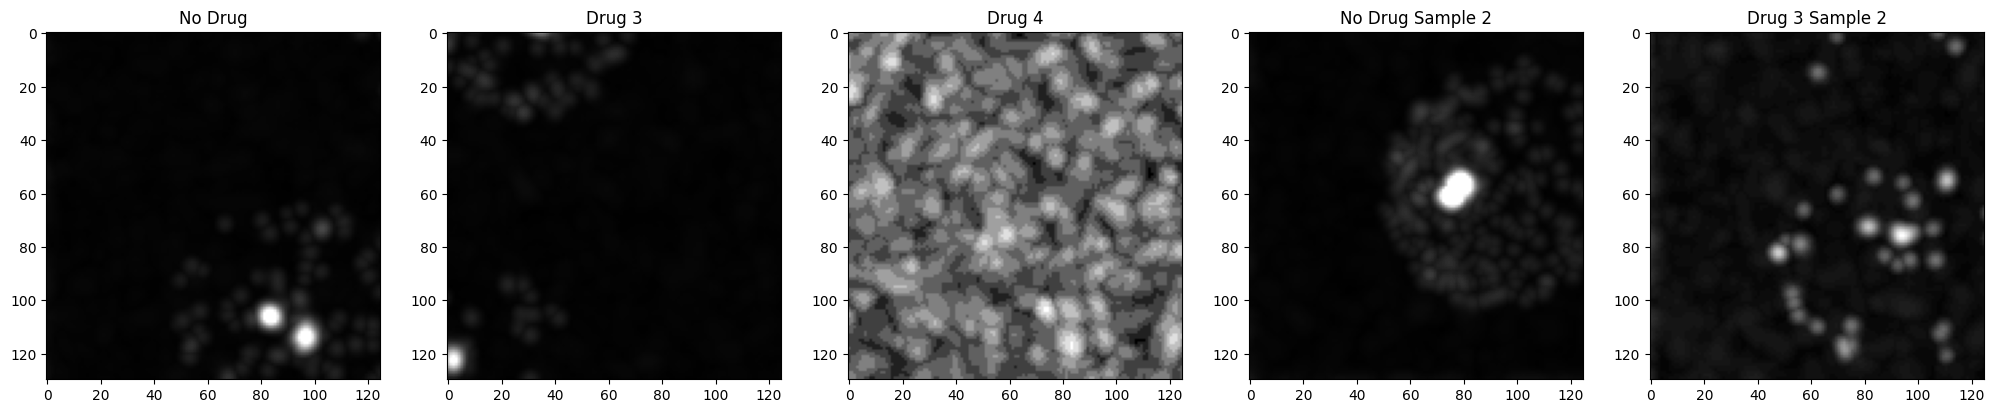

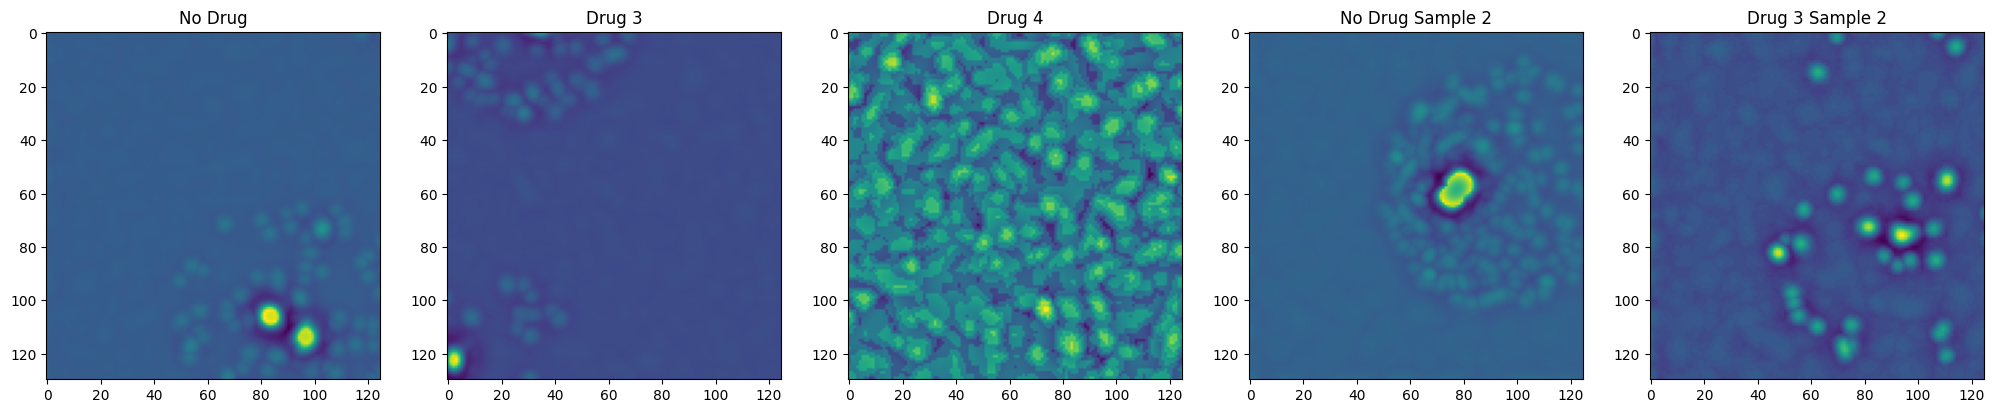

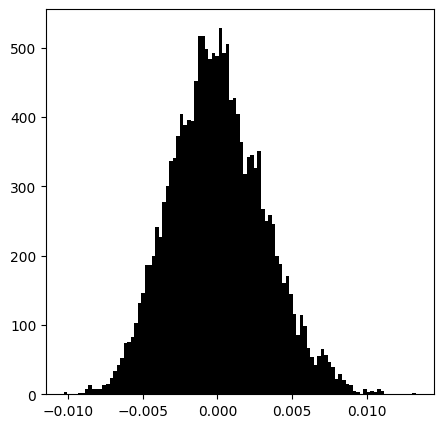

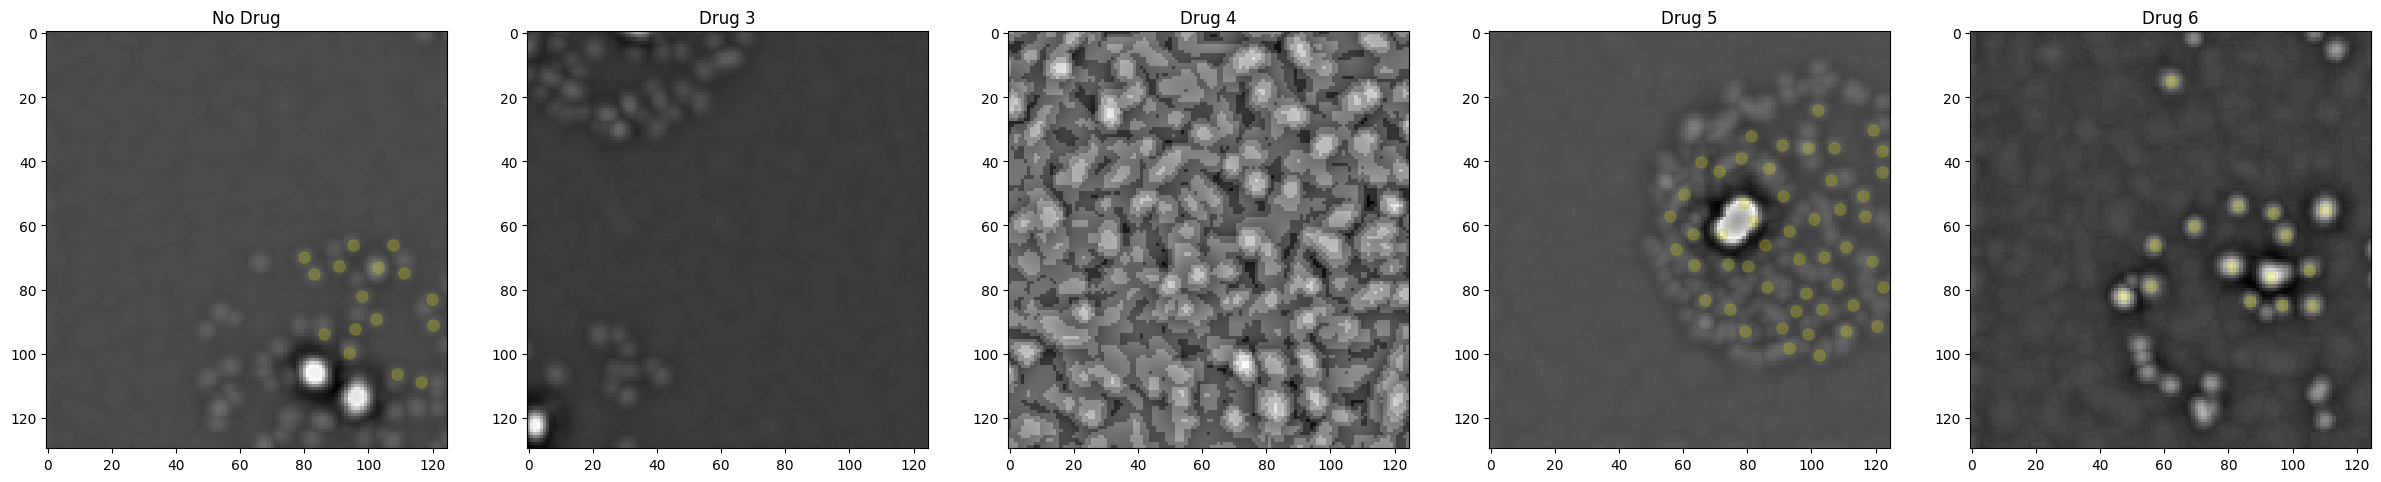

In [14]:
#  2) trying a difference of gaussians to improve trackpy (compare to next cell of images done without difference of gaussians)

from skimage.filters import difference_of_gaussians

# cropping images
CropNoDrug = NoDrugMax[70:200, 0:125]
CropDrug3 = Drug3Max[210:340, 215:340]
CropDrug4 = Drug4Max[410:540, 15:140]
CropDrug5 = Drug5Max[520:650, 0:125]
CropDrug6 = Drug6Max[285:415, 0:125]
img_spots_filtered = np.zeros((130, 125, 6))

# plot all cropped images
fig, ax = plt.subplots(1, 5, figsize=(25, 7))
fig1, ax1 = plt.subplots(1, 5, figsize=(25, 7))
for i in range(0,5):
    img = [CropNoDrug, CropDrug3, CropDrug4, CropDrug5, CropDrug6][i]
    title1 = ['No Drug', 'Drug 3', 'Drug 4', 'No Drug Sample 2', 'Drug 3 Sample 2', 'Drug 4 Sample 2'][i]
    ax[i].imshow(img[:, :, 2], cmap='gray')
    ax[i].set(title = title1)
    img_spots = img[:,:,2]
    img_spots_filtered[:, :, i] = difference_of_gaussians(img_spots,low_sigma=0.25, high_sigma=4)
    ax1[i].imshow(img_spots_filtered[:, :, i])
    ax1[i].set(title = title1)
fig3, ax3 = plt.subplots(1, 1, figsize = (5, 5))
ax3.hist(img_spots_filtered[:,:,2].flatten(), bins=100, color='k')

selected_intensity = 0
selected_size = 5

# running TrackPy to find protein spots for all sample images

fig4, ax4 = plt.subplots(1, 5, figsize=(30, 7))

for j in range(0, 5):
    img = img_spots_filtered[:, :, j]
    #img = [CropNoDrug1, CropDrug3, CropDrug4, CropNoDrug2, CropDrug32, CropDrug42][j]
    masks_cyto = cytomasks[j, :, :]

    #ch = 2
    df_TrackPy = tp.locate(img[:,:],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    df_TrackPy['frame'] = 0

    for iFrame in range(1,img.shape[0]):
        f = tp.locate(img[:,:],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
        f['frame'] = iFrame
        df_TrackPy = pd.concat([df_TrackPy,f])

    selected_masks =  np.where(masks_cyto != 0, 1, 0)

    def spots_in_mask(f,mask):
        # extracting the contours in the image
        coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
        coords_int = np.round(coords).astype(int)  # or np.floor, depends
        values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
        f['In Mask']=values_at_coords # Check if pts are on/in polygon mask
        return f

    # Remove spots that are not contained in the cell masks
    df_masked = spots_in_mask(df_TrackPy,selected_masks)
    dataframe_particles_in_mask = df_masked[df_masked['In Mask']==True]
    dfp = dataframe_particles_in_mask

    frame = 6
    ax4[j].imshow(img[:,:],cmap= 'gray')
    dfp = dfp[dfp['frame']==frame]

    for i in range(0,dfp.shape[0]):
        x_val = dfp.iloc[i][1]
        y_val = dfp.iloc[i][0]
        ax4[j].plot(x_val,y_val, 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)
    title = ['No Drug', 'Drug 3', 'Drug 4', 'Drug 5', 'Drug 6'][j]
    ax4[j].set(title = title)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

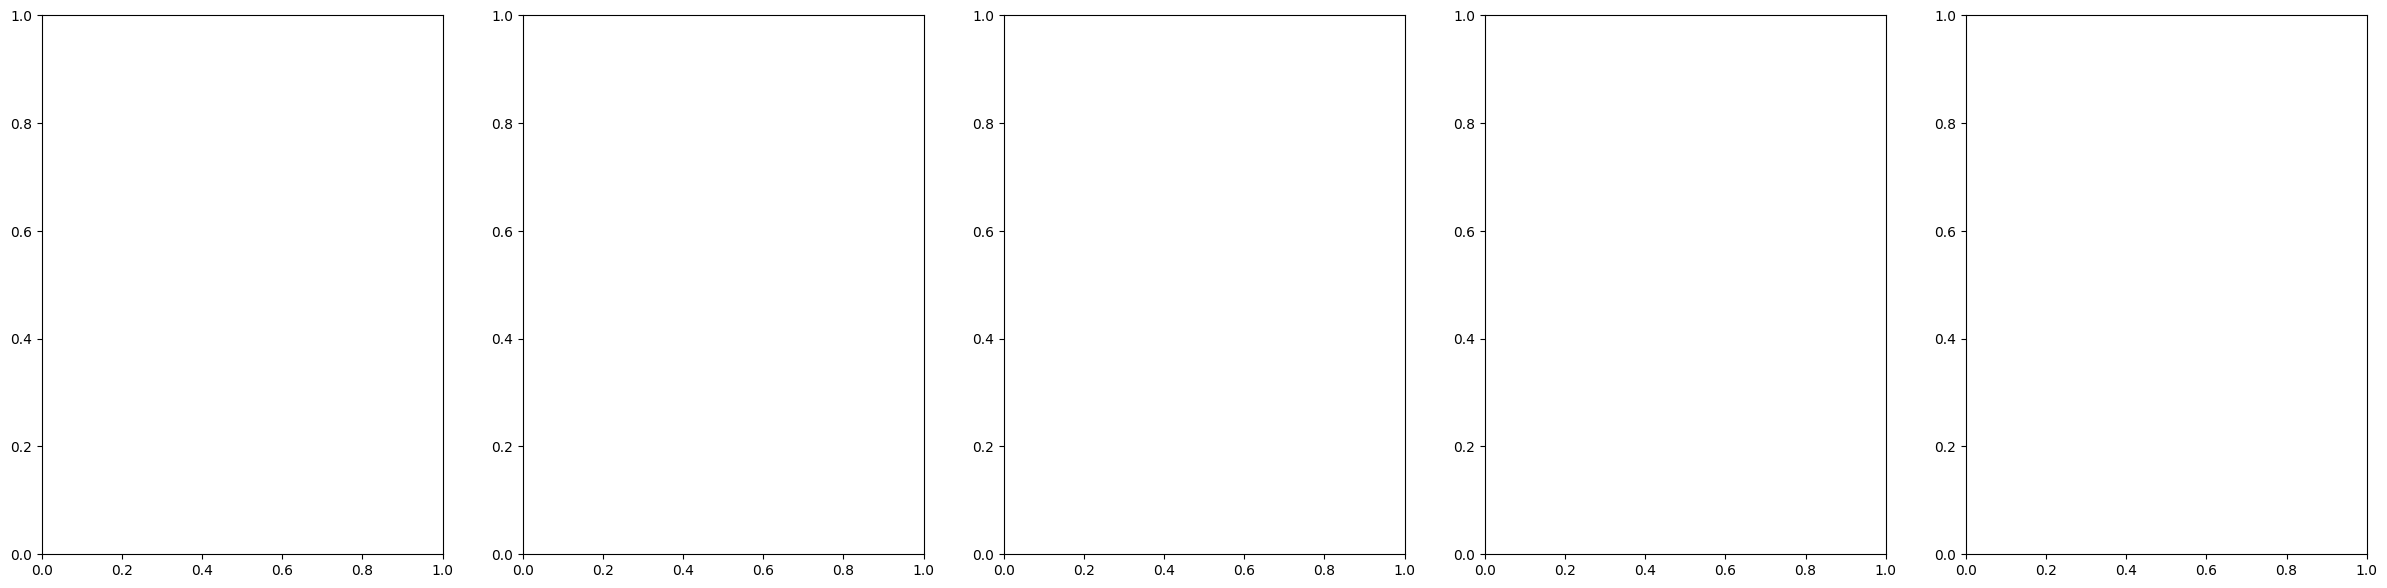

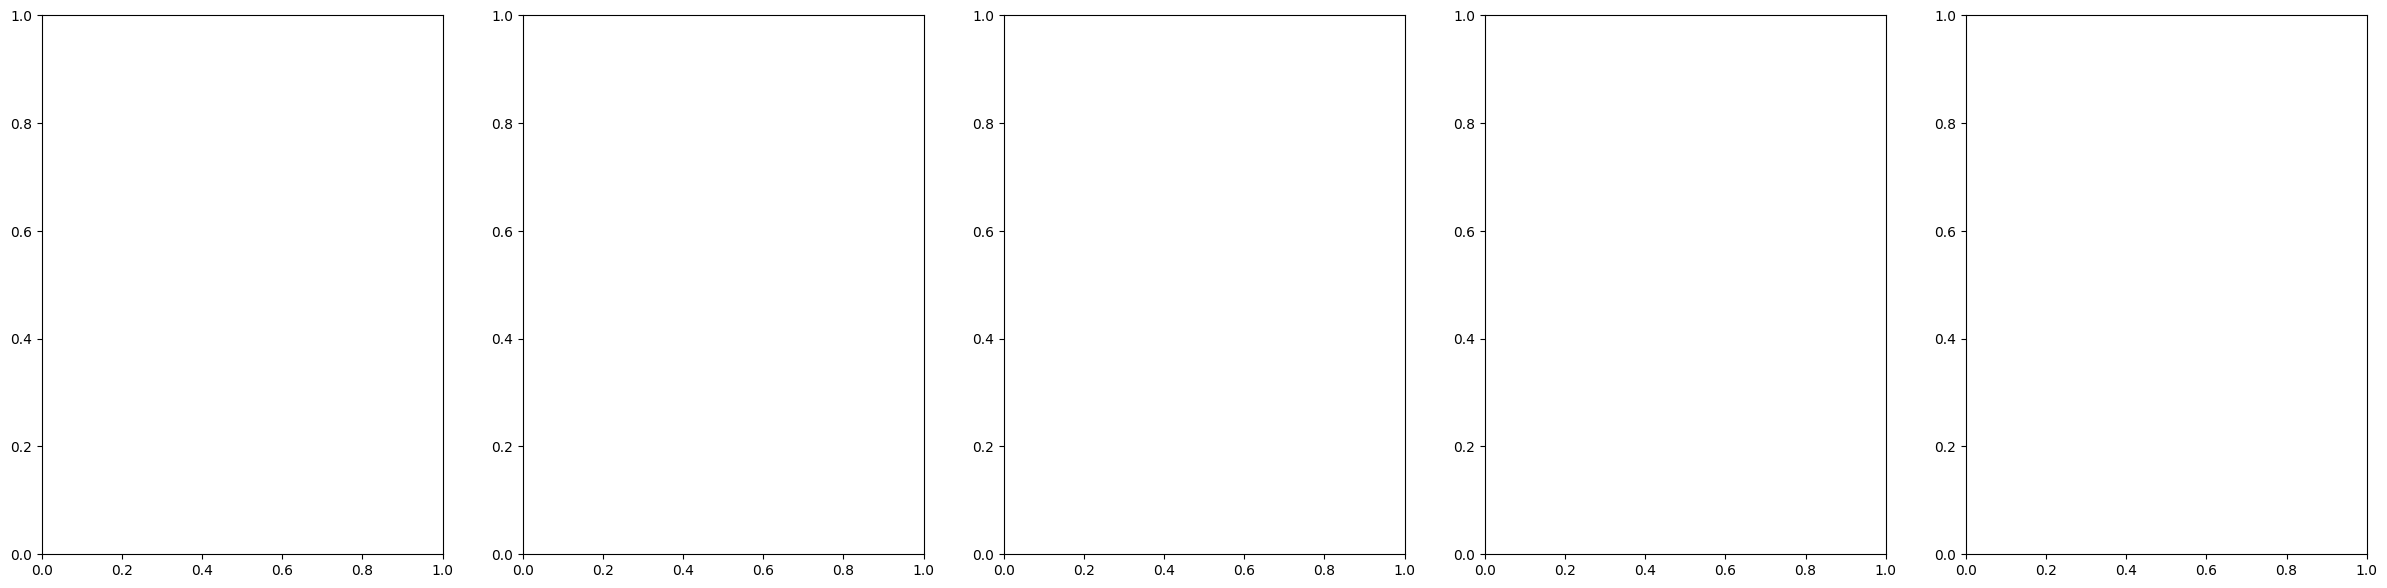

In [13]:
def spots_in_mask(f,mask):
    # extracting the contours in the image
    coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    f['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return f

selected_intensity = 200
selected_size = 21

# running TrackPy to find protein spots for all sample images at frame 6

fig3, ax3 = plt.subplots(1, 5, figsize=(30, 7))
fig4, ax4 = plt.subplots(1, 5, figsize=(30, 7))

for j in range(0, 5):
    img = [CropNoDrug, CropDrug3, CropDrug4, CropDrug5, CropDrug6][j]
    masks_cyto = cytomasks[j, :, :]
    ch = 2
    df_TrackPy = tp.locate(img[0,:,:,ch],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    df_TrackPy['frame'] = 0

    for iFrame in range(1,img.shape[0]):
        f = tp.locate(img[iFrame,:,:,ch],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
        f['frame'] = iFrame
        df_TrackPy = pd.concat([df_TrackPy,f])

    selected_masks =  np.where(masks_cyto != 0, 1, 0)

    # Remove spots that are not contained in the cell masks
    df_masked = spots_in_mask(df_TrackPy,selected_masks)
    dataframe_particles_in_mask = df_masked[df_masked['In Mask']==True]
    dfp = dataframe_particles_in_mask

    frame = 6
    ax3[j].imshow(img[frame,:,:,2],cmap= 'gray')
    dfp = dfp[dfp['frame']==frame]

    for i in range(0,dfp.shape[0]):
        x_val = dfp.iloc[i][1]
        y_val = dfp.iloc[i][0]
        ax3[j].plot(x_val,y_val, 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)
    title = ['No Drug', 'Drug 3', 'Drug 4', 'No Drug Sample 2', 'Drug 3 Sample 2', 'Drug 4 Sample 2'][j]
    ax3[j].set(title = title)

# cropped version of results to show more detail
for j in range(0, 5):
    img = [CropNoDrug, CropDrug3, CropDrug4, CropDrug5, CropDrug6][j]
    masks_cyto = cytomasks[j, :, :]
    ch = 2
    df_TrackPy = tp.locate(img[:,:,ch],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    df_TrackPy['frame'] = 0
    selected_masks =  np.where(masks_cyto != 0, 1, 0)

    # Remove spots that are not contained in the cell masks
    df_masked = spots_in_mask(df_TrackPy,selected_masks)
    dataframe_particles_in_mask = df_masked[df_masked['In Mask']==True]
    dfp = dataframe_particles_in_mask

    ax4[j].imshow(img[:,:,2],cmap= 'gray')

    for i in range(0,dfp.shape[0]):
        x_val = dfp.iloc[i][1]
        y_val = dfp.iloc[i][0]
        ax4[j].plot(x_val,y_val, 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)
    title = ['No Drug', 'Drug 3', 'Drug 4', 'Drug5', 'Drug 6'][j]
    ax4[j].set(title = title)

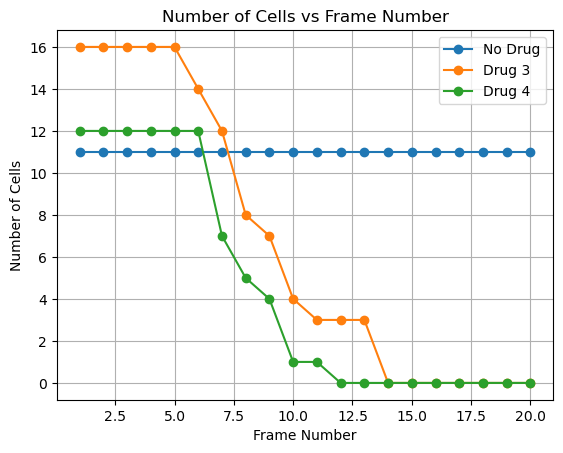

In [ ]:
#3) Plots of cell survival fraction versus time for each of the three samples.

# Define the paths to the TIFF files
file_paths = ['./NoDrug/rep1_FOV1.tif', './Drug3_1000nM/rep2_FOV1.tif', './Drug4_1000nM/rep2_FOV1.tif']

# Create empty variables to store cell count vectors
countNoDrug = []
countDrug3 = []
countDrug4 = []

# Iterate through each TIFF file
for file_path in file_paths:
    # Load the TIFF image
    img = imread(file_path)

    # Create an empty vector to store cell counts
    cell_counts_vector = np.zeros(20)  # Assuming there are 20 frames in total

    # Iterate through each frame of the image
    for frame_num in range(1, 21):  # Assuming there are 20 frames in total
        # Extract the current frame from the image
        img_nuc = img[frame_num - 1, :, :, 0]  # Assuming nuclei are in the first channel

        # Segmenting the nuclei for the current frame
        use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
        model = models.Cellpose(gpu=use_GPU, model_type='nuclei')  # model_type='cyto' or model_type='nuclei'
        masks_nuc = model.eval(img_nuc, diameter=100, channels=[0, 1])[0]

        # Count the number of cells in nuclei segmentation for the current frame
        num_cells_nuc = len(np.unique(masks_nuc)) - 1  # Subtracting 1 to exclude background

        # Store the cell count in the vector
        cell_counts_vector[frame_num - 1] = num_cells_nuc

    # Store the cell count vector in the corresponding variable
    if 'NoDrug' in file_path:
        countNoDrug = cell_counts_vector
    elif 'Drug3' in file_path:
        countDrug3 = cell_counts_vector
    elif 'Drug4' in file_path:
        countDrug4 = cell_counts_vector

# Plot cell counts versus frame numbers
labels = ['No Drug', 'Drug 3', 'Drug 4']
for file_path, label in zip(file_paths, labels):
    img = imread(file_path)
    cell_counts_vector = np.zeros(20)
    for frame_num in range(1, 21):
        img_nuc = img[frame_num - 1, :, :, 0]
        model = models.Cellpose(gpu=False, model_type='nuclei')
        masks_nuc = model.eval(img_nuc, diameter=100, channels=[0, 1])[0]
        num_cells_nuc = len(np.unique(masks_nuc)) - 1
        cell_counts_vector[frame_num - 1] = num_cells_nuc
    frame_numbers = np.arange(1, len(cell_counts_vector) + 1)
    plt.plot(frame_numbers, cell_counts_vector, marker='o', label=label)

# Add labels and title
plt.xlabel('Frame Number')
plt.ylabel('Number of Cells')
plt.title('Number of Cells vs Frame Number')
plt.legend()
plt.grid(True)
plt.show()


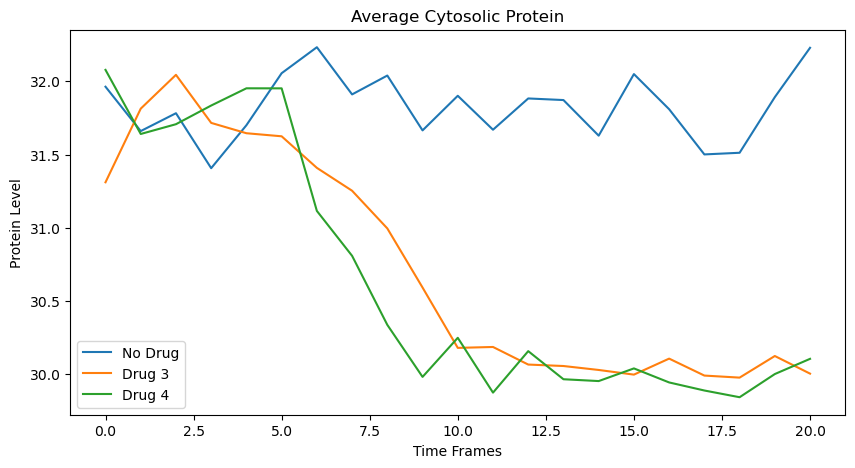

In [ ]:
#4) Plots of average cytosolic protein levels versus time for the three samples.

tempaverages1 = np.zeros((6, img.shape[0]))
averages = np.zeros((3, img.shape[0]))

# finding the average protein levels for each sample chosen
for i in range(0,6):
    for j in range(0, img.shape[0]):
        img = [imgNoDrug, imgDrug3, imgDrug4, imgNoDrug2, imgDrug32, imgDrug42][i]
        avg = np.sum(img[j, :, :, 2]*cytomasks[i, :, :])/np.sum(cytomasks[i, :, :])
        tempaverages1[i, j] = avg

# averaging results for no drug, drug 3, and drug 4
for i in range(0,3):
    for j in range(0,img.shape[0]):
        set1 = tempaverages1[i, j]
        set2 = tempaverages1[i+3, j]
        averages[i, j] = np.average([set1, set2])

fig4, ax4 = plt.subplots(1, figsize=(10, 5))
time = np.arange(0, img.shape[0])
ax4.plot(time, averages[0,:], label = 'No Drug')
ax4.plot(time, averages[1,:], label = 'Drug 3')
ax4.plot(time, averages[2,:], label = 'Drug 4')
ax4.set(title = 'Average Cytosolic Protein', xlabel = 'Time Frames', ylabel = 'Protein Level')
ax4.legend()

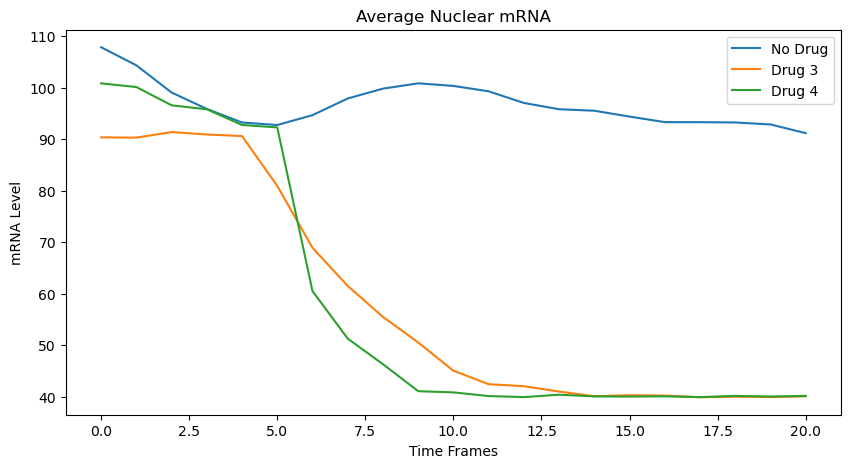

In [ ]:
#5) Plots of average nuclear mRNA versus time for the three samples.

tempaverages = np.zeros((6, img.shape[0]))
averages = np.zeros((3, img.shape[0]))

# finding the average nuclear mRNA for each sample chosen
for i in range(0,6):
    for j in range(0, img.shape[0]):
        img = [imgNoDrug, imgDrug3, imgDrug4, imgNoDrug2, imgDrug32, imgDrug42][i]
        avg = np.sum(img[j, :, :, 1]*nucmasks[i, :, :])/np.sum(nucmasks[i, :, :])
        tempaverages[i, j] = avg

# averaging results for no drug, drug 3, and drug 4
for i in range(0,3):
    for j in range(0,img.shape[0]):
        set1 = tempaverages[i, j]
        set2 = tempaverages[i+3, j]
        averages[i, j] = np.average([set1, set2])

fig4, ax4 = plt.subplots(1, figsize=(10, 5))
time = np.arange(0, img.shape[0])
ax4.plot(time, averages[0,:], label = 'No Drug')
ax4.plot(time, averages[1,:], label = 'Drug 3')
ax4.plot(time, averages[2,:], label = 'Drug 4')
ax4.set(title = 'Average Nuclear mRNA', xlabel = 'Time Frames', ylabel = 'mRNA Level')
ax4.legend()

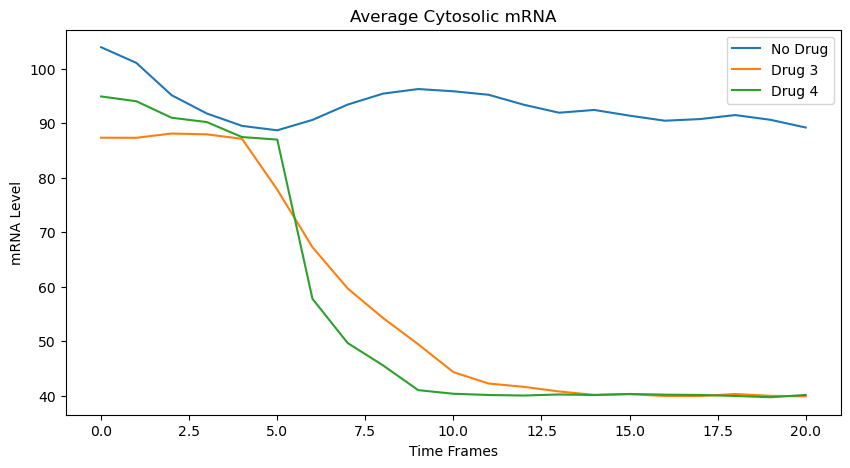

In [ ]:
#6) Plots of average cytoplasmic mRNA versus time for the three samples.

tempaverages = np.zeros((6, img.shape[0]))
averages = np.zeros((3, img.shape[0]))
masks = cytomasks - nucmasks

# finding the average protein levels for each sample chosen
for i in range(0,6):
    for j in range(0, img.shape[0]):
        img = [imgNoDrug, imgDrug3, imgDrug4, imgNoDrug2, imgDrug32, imgDrug42][i]
        avg = np.sum(img[j, :, :, 1]*masks[i, :, :])/np.sum(masks[i, :, :])
        tempaverages[i, j] = avg

# averaging results for no drug, drug 3, and drug 4
for i in range(0,3):
    for j in range(0,img.shape[0]):
        set1 = tempaverages[i, j]
        set2 = tempaverages[i+3, j]
        averages[i, j] = np.average([set1, set2])

fig4, ax4 = plt.subplots(1, figsize=(10, 5))
time = np.arange(0, img.shape[0])
ax4.plot(time, averages[0,:], label = 'No Drug')
ax4.plot(time, averages[1,:], label = 'Drug 3')
ax4.plot(time, averages[2,:], label = 'Drug 4')
ax4.set(title = 'Average Cytosolic mRNA', xlabel = 'Time Frames', ylabel = 'mRNA Level')
ax4.legend()

In [ ]:
#7) Statistical analysis of the cell vitality (fraction of cells that survive to the end of the video) 
# to compare the control and two drugs.  Use ANOVA.

# Assuming countNoDrug, countDrug3, and countDrug4 are already defined with the cell count vectors

# Perform one-way ANOVA for Drug 3
f_statistic_drug3, p_value_drug3 = f_oneway(countNoDrug, countDrug3)

# Perform one-way ANOVA for Drug 4
f_statistic_drug4, p_value_drug4 = f_oneway(countNoDrug, countDrug4)

# Print the results for Drug 3
print("One-way ANOVA results for Drug 3:")
print("F-statistic:", f_statistic_drug3)
print("p-value:", p_value_drug3)

# Interpret the results for Drug 3
alpha = 0.05
if p_value_drug3 < alpha:
    print("The differences between the means for No Drug and Drug 3 are statistically significant.")
else:
    print("The differences between the means for No Drug and Drug 3 are not statistically significant.")

# Print the results for Drug 4
print("\nOne-way ANOVA results for Drug 4:")
print("F-statistic:", f_statistic_drug4)
print("p-value:", p_value_drug4)

# Interpret the results for Drug 4
if p_value_drug4 < alpha:
    print("The differences between the means for No Drug and Drug 4 are statistically significant.")
else:
    print("The differences between the means for No Drug and Drug 4 are not statistically significant.")


One-way ANOVA results for Drug 3:
F-statistic: 8.000683215668413
p-value: 0.00742450669149807
The differences between the means for No Drug and Drug 3 are statistically significant.

One-way ANOVA results for Drug 4:
F-statistic: 29.137931034482758
p-value: 3.8083767745087823e-06
The differences between the means for No Drug and Drug 4 are statistically significant.


In [ ]:
#8) Statistical analysis of the protein expression in living cells (at the end of the video) 
# to compare the control and the two drugs. Use ANOVA.

# Assuming protein_expression_control, protein_expression_drug1, and protein_expression_drug2 are already defined
control = [tempaverages1[0, 20], tempaverages1[3, 20]]
drug3 = [tempaverages1[1, 20], tempaverages1[4, 20]]
drug4 = [tempaverages1[2, 20], tempaverages1[5, 20]]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(control, drug3, drug4)

# Print the results
print("One-way ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The differences between the means for the control and the drugs are statistically significant.")
else:
    print("The differences between the means for the control and the drugs are not statistically significant.")


One-way ANOVA results:
F-statistic: 35.37389440328989
p-value: 0.008204618219664936
The differences between the means for the control and the drugs are statistically significant.


In [ ]:
#8) Statistical analysis of the protein expression in living cells (at the end of the video) 
# to compare the control and the two drugs. Use ANOVA.

# Perform one-way ANOVA for Drug 3
f_statistic_drug3, p_value_drug3 = f_oneway(control, drug3)

# Perform one-way ANOVA for Drug 4
f_statistic_drug4, p_value_drug4 = f_oneway(control, drug4)

# Print the results for Drug 3
print("One-way ANOVA results for Drug 3:")
print("F-statistic:", f_statistic_drug3)
print("p-value:", p_value_drug3)

# Interpret the results for Drug 3
alpha = 0.05
if p_value_drug3 < alpha:
    print("The differences between the means for No Drug and Drug 3 are statistically significant.")
else:
    print("The differences between the means for No Drug and Drug 3 are not statistically significant.")

# Print the results for Drug 4
print("\nOne-way ANOVA results for Drug 4:")
print("F-statistic:", f_statistic_drug4)
print("p-value:", p_value_drug4)

# Interpret the results for Drug 4
if p_value_drug4 < alpha:
    print("The differences between the means for No Drug and Drug 4 are statistically significant.")
else:
    print("The differences between the means for No Drug and Drug 4 are not statistically significant.")


One-way ANOVA results for Drug 3:
F-statistic: 37.51497840015623
p-value: 0.02563544741718215
The differences between the means for No Drug and Drug 3 are statistically significant.

One-way ANOVA results for Drug 4:
F-statistic: 33.78736177876776
p-value: 0.028344531587658966
The differences between the means for No Drug and Drug 4 are statistically significant.
